In [7]:
# Instalare pachete necesare pentru rularea notebookului

!pip install pandas numpy matplotlib seaborn fuzzywuzzy 



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import warnings
warnings.filterwarnings('ignore')


In [9]:
import pandas as pd
# Citire data din CSV
df = pd.read_csv("movies_metadata.csv", low_memory=False)

print(df.shape)
print(df.columns)


(45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [10]:
import pandas as pd
import numpy as np

# Calculam procentul de valori lipsa (NaN) pentru fiecare coloana
missing = df.isna().mean().sort_values(ascending=False)
print(missing)


belongs_to_collection    0.901157
homepage                 0.828839
tagline                  0.551049
overview                 0.020983
poster_path              0.008490
runtime                  0.005785
status                   0.001914
release_date             0.001914
imdb_id                  0.000374
original_language        0.000242
vote_average             0.000132
vote_count               0.000132
title                    0.000132
video                    0.000132
spoken_languages         0.000132
revenue                  0.000132
popularity               0.000110
production_countries     0.000066
production_companies     0.000066
genres                   0.000000
id                       0.000000
adult                    0.000000
budget                   0.000000
original_title           0.000000
dtype: float64


### Curatarea si imputarea valorilor lipsa

In aceasta etapa am tratat valorile lipsa si am eliminat coloanele care nu aduc informatii utile pentru analiza.
Scopul a fost sa pastram doar atribute relevante si sa facem datele coerente pentru etapele urmatoare.

**Cum am procedat:**
1. Am eliminat coloanele ne-analitice sau redundante (`homepage`, `poster_path`, `id`, `imdb_id`, `video`, `adult`, `original_title`).
   Acestea fie contineau identificatori unici, fie informatii irelevante (linkuri, imagini, campuri constante).
2. Am completat valorile lipsa in campurile textuale:
   - `tagline` completat cu mesaj neutru ("No tagline provided")
   - `overview` completat cu sir gol pentru a nu afecta alte analize
3. Am completat valorile lipsa in campurile categorice:
   - `status` completat cu "unknown" (procent mic de valori lipsa)
4. Am tratat campurile numerice (`budget`, `revenue`, `runtime`, `popularity`):
   - Am convertit toate valorile la tip numeric pentru a putea fi folosite în calcule și grafice.
   - Am înlocuit valorile 0 cu NaN, deoarece 0 înseamnă lipsă de informație, nu valoare reală.
   - Pentru budget și revenue, am păstrat valorile lipsă ca NaN și am creat coloane indicator (has_budget, has_revenue) care arată dacă informația există.
   - Pentru runtime si popularity, am completat valorile lipsă cu mediana, deoarece are puține lipsuri și mediana este mai robustă la valori extreme.
5. Am convertit coloana `release_date` in format datetime si am eliminat randurile fara data valida.
   Data lansarii este esentiala pentru analize temporale, iar procentul de lipsa a fost nesemnificativ.
6. Am tratat `belongs_to_collection`:
   - Valoarea lipsa aici inseamna "nu face parte dintr-o colectie"
   - Am inlocuit valorile lipsa cu "None" si am creat o noua variabila binara `in_collection` (0/1) pentru modele.

**De ce am facut asta:**
- Pentru a evita erori in analizele numerice si temporale
- Pentru a pastra consistenta datelor
- Pentru a elimina coloane redundante sau fara valoare analitica




In [11]:
# Elimin coloane ne-analitice sau cu procent mare de lipsuri
# - homepage, poster_path: URL/imagini, nu aduc valoare analitica
# - imdb_id, id: identificatori unici -> utili doar pentru join, nu pentru modele
# - adult, video: aproape constante in setul acesta
# - original_title: duplicat/coloana nerelevanta pentru analiza
drop_cols = [c for c in [
    "homepage", "poster_path", "imdb_id", "id", "adult", "video", "original_title"
] if c in df.columns]
df.drop(columns=drop_cols, inplace=True)

# Imputare text
# - tagline are ~55% lipsuri -> completam cu mesaj neutru ca să nu pierdem randuri
# - overview are ~2% lipsuri -> completam cu sir gol (nu influenteaza medii/numere)
if "tagline" in df.columns:
    df["tagline"] = df["tagline"].fillna("No tagline provided")
if "overview" in df.columns:
    df["overview"] = df["overview"].fillna("")

# Imputare categorica
# - status are ~0.2% lipsuri -> completam cu "unknown" pentru a pastra randurile
if "status" in df.columns:
    df["status"] = df["status"].fillna("unknown")

# Conversie numerica si tratare valori lipsa
# - convertim la numeric (unele campuri pot fi string)
# - in acest set, valoarea 0 semnifica de multe ori lipsa -> mapam 0 -> NaN
# - imputam cu mediana (robust la outlieri, mai potrivita decat media)
df["budget"]  = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
df["runtime"] = pd.to_numeric(df["runtime"], errors="coerce")
df["popularity"] = pd.to_numeric(df["popularity"], errors="coerce")


df.loc[df["budget"] == 0, "budget"] = np.nan
df.loc[df["revenue"] == 0, "revenue"] = np.nan
df.loc[df["runtime"] == 0, "runtime"] = np.nan

# 2. Creez coloane indicator
df["has_budget"] = np.where(df["budget"].isna(), 0, 1)
df["has_revenue"] = np.where(df["revenue"].isna(), 0, 1)
df["runtime"] = df["runtime"].fillna(df["runtime"].median())

# Date calendaristice
# - release_date este esentiala pentru analize pe timp; randurile fara data sunt foarte putine
# -> le eliminam pentru a evita erori ulterioare la parsare si feature engineering
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
if "release_date" in df.columns:
    df = df[df["release_date"].notna()]

# feature engineering
# - belongs_to_collection are ~90% lipsuri dar asta nu este eroare; inseamna ca filmul nu are colectie
# - pastram informatia: umplem cu "None" si cream o variabila binara 
if "belongs_to_collection" in df.columns:
    df["belongs_to_collection"] = df["belongs_to_collection"].fillna("None")
    df["in_collection"] = np.where(df["belongs_to_collection"] == "None", 0, 1)

# 7) Verificare finala
print("Missing values after cleaning:")
print(df.isna().sum().sort_values(ascending=False).head(15))
print("\nDataset shape:", df.shape)


Missing values after cleaning:
revenue                  37969
budget                   36490
original_language           11
belongs_to_collection        0
genres                       0
overview                     0
production_companies         0
popularity                   0
production_countries         0
release_date                 0
runtime                      0
spoken_languages             0
status                       0
tagline                      0
title                        0
dtype: int64

Dataset shape: (45376, 20)


### Curatarea valorilor textuale scurte (fuzzy normalization)

Scopul acestui pas este sa facem valorile din campurile textuale scurte mai consistente.
De exemplu, valorile "Released", "released" si "released " trebuie considerate aceeasi categorie.

**Cum am procedat:**
1. Am transformat toate valorile in litere mici si am eliminat spatiile suplimentare.
2. Pentru fiecare valoare, am cautat cea mai asemanatoare eticheta corecta dintr-o lista predefinita folosind fuzzy matching.
3. Daca asemanarea depasea un prag (90%), valoarea a fost inlocuita cu eticheta corecta.

**De ce am facut asta:**
Campurile categorice scurte pot avea erori de scriere, spatii inutile sau litere mari/mici diferite.
Curatarea lor ajuta la uniformizarea datelor si previne dublarea categoriilor in analiza.

**Unde am aplicat:**
Aceasta metoda a fost folosita doar pe coloanele `status` si `original_language`, 
nu pe texte lungi (precum descrierea filmului) sau pe valori numerice/date.


In [12]:
from fuzzywuzzy import process, fuzz
import pandas as pd

# Functie care normalizeaza textul: il transforma in litere mici si elimina spatiile goale
def normalize_text(s: pd.Series) -> pd.Series:
    return s.astype("string").str.lower().str.strip()

# Functie care aplica fuzzy matching pentru a uniformiza valorile dintr-o coloana
def fuzzy_map_to_canon(series: pd.Series, canon_labels, threshold: int = 90) -> pd.Series:
    """
    Compara fiecare valoare din coloana cu o lista de etichete corecte.
    Daca similaritatea e peste pragul stabilit (threshold), o inlocuieste cu eticheta corecta.
    """
    # normalizam atat valorile din coloana, cat si lista de etichete canonice
    s = normalize_text(series)
    canon = [c.lower().strip() for c in canon_labels]

    # functie interna pentru un singur element
    def _map_one(x):
        if pd.isna(x) or x == "":
            return x  # pastram valorile lipsa
        best, score = process.extractOne(x, canon, scorer=fuzz.token_sort_ratio)
        return best if score >= threshold else x  # inlocuim doar daca e destul de asemanator

    return s.apply(_map_one)


# Aplicam fuzzy cleaning pe coloana 'status'
if "status" in df.columns:
    status_canon = ["Released", "Planned", "Rumored", "Post Production", "Canceled", "In Production"]
    print("Before (status):")
    print(df["status"].value_counts(dropna=False).head(10), "\n")

    # aplicam functia definita mai sus
    df["status"] = fuzzy_map_to_canon(df["status"], status_canon, threshold=90)

    print("After (status):")
    print(df["status"].value_counts(dropna=False).head(10), "\n")


# Aplicam fuzzy cleaning pe coloana 'original_language'
if "original_language" in df.columns:
    lang_canon = ["en","fr","es","de","it","ja","ko","zh","ru","hi","pt","ar","nl","tr","sv","no","da","fi","pl","ro"]
    print("Before (original_language):")
    print(df["original_language"].value_counts(dropna=False).head(10), "\n")

    # aplicam aceeasi logica ca mai sus
    df["original_language"] = fuzzy_map_to_canon(df["original_language"], lang_canon, threshold=90)

    print("After (original_language):")
    print(df["original_language"].value_counts(dropna=False).head(10), "\n")


Before (status):
status
Released           44936
Rumored              230
Post Production       97
unknown               80
In Production         19
Planned               13
Canceled               1
Name: count, dtype: int64 

After (status):
status
released           44936
rumored              230
post production       97
unknown               80
in production         19
planned               13
canceled               1
Name: count, dtype: int64 

Before (original_language):
original_language
en    32202
fr     2437
it     1528
ja     1349
de     1078
es      992
ru      822
hi      508
ko      444
zh      408
Name: count, dtype: int64 

After (original_language):
original_language
en    32202
fr     2437
it     1528
ja     1349
de     1078
es      992
ru      822
hi      508
ko      444
zh      408
Name: count, dtype: int64 



### Codificarea variabilei `original_language`

** Pas 1: Selectam cele mai frecvente 10 limbi 

** Pas 2: Inlocuim limbile rare cu o categorie comuna "other" 

** Pas 3: Aplicam One-Hot Encoding pentru a transforma textul in valori numerice (0/1) 

** Pas 4: drop_first=True elimina o coloana redundanta pentru a evita multicoliniaritatea 

**De ce am facut asta:**  
Aceasta transformare este necesara deoarece algoritmii de invatare automata nu pot lucra direct cu text.  
Astfel, informatia despre limbile principale se pastreaza, iar valorile rare sunt grupate intr-o singura categorie pentru a evita zgomotul in date.


In [13]:
top_langs = df['original_language'].value_counts().nlargest(10).index
df['original_language'] = df['original_language'].where(df['original_language'].isin(top_langs), 'other')
df = pd.get_dummies(df, columns=['original_language'], drop_first=True, dtype='uint8')




### Codificarea variabilei main_genre

** Pas 1: Extragem genul principal din coloana genres
Coloana genres contine liste de dictionare (ex.: [{id: 16, name: "Animation"}, ...]).
Pentru a putea lucra mai usor, extragem doar primul gen din lista si il salvam intr-o noua coloana main_genre.

** Pas 2: Selectam cele mai frecvente 10 genuri
Calculam distributia valorilor din main_genre si pastram doar primele 10 genuri ca frecventa.
Genurile foarte rare sunt mai putin informative si pot introduce zgomot in model.

** Pas 3: Inlocuim genurile rare cu o categorie comuna "other"
Toate genurile care nu se afla in top 10 sunt inlocuite cu eticheta "other".
Astfel, reducem numarul de categorii si evitam sparsitatea excesiva in date.

** Pas 4: Aplicam One-Hot Encoding asupra main_genre
Transformam coloana main_genre in mai multe coloane binare (main_genre_Action, main_genre_Comedy, etc.),
fiecare avand valori 0/1 care indica prezenta sau absenta genului respectiv pentru un film.

** Pas 5: Folosim drop_first=True pentru a evita multicoliniaritatea
Prin drop_first=True, eliminam una dintre coloanele rezultate (coloana de referinta).
Astfel, evitam redundanta completa dintre variabilele dummy si posibile probleme numerice pentru unii algoritmi.

**De ce am facut asta:**
Algoritmii de invatare automata nu pot lucra direct cu text sau structuri de tip lista/dictionar.
Prin extragerea genului principal si aplicarea One-Hot Encoding:

- pastram informatia esentiala despre tipul filmului (comedy, action, drama etc.),

- reducem complexitatea prin gruparea genurilor rare in "other",

- obtinem variabile numerice clare (0/1), potrivite pentru modelele de clasificare,

- evitam zgomotul si supradimensionarea spatiului de feature-uri.

In [14]:
import ast
import pandas as pd

def extract_main_genre(genre_list):
    if pd.isna(genre_list) or genre_list == "[]":
        return "other"
    try:
        genres = ast.literal_eval(genre_list)
        if len(genres) > 0:
            return genres[0]["name"]   # DOAR GENUL PRINCIPAL
        return "other"
    except:
        return "other"

df["main_genre"] = df["genres"].apply(extract_main_genre)


In [15]:
# 0. extrage anul
df["release_year"] = pd.to_datetime(df["release_date"]).dt.year

# 1. Top genuri
top_genres = df['main_genre'].value_counts().nlargest(10).index

# 2. Genurile rare -> 'other'
df['main_genre'] = df['main_genre'].where(
    df['main_genre'].isin(top_genres),
    'other'
)

# 3. One-hot pentru main_genre
df = pd.get_dummies(
    df,
    columns=['main_genre'],
    drop_first=True,
    dtype='uint8'
)

print([c for c in df.columns if c.startswith("main_genre_")])


['main_genre_Adventure', 'main_genre_Comedy', 'main_genre_Crime', 'main_genre_Documentary', 'main_genre_Drama', 'main_genre_Horror', 'main_genre_Romance', 'main_genre_Thriller', 'main_genre_other']


### Analiza si transformarea valorilor numerice

Scopul acestei etape a fost sa reducem influenta valorilor extreme (outlieri)
si sa obtinem distributii numerice mai echilibrate, mai potrivite pentru analize si modele.

**Cum am procedat:**
1. Am aplicat transformarea logaritmica pentru coloanele budget, revenue si runtime.
2. Am calculat si vizualizat distributiile log-transformate prin histograme, pentru a observa echilibrarea datelor.

**De ce am facut asta:**
Valorile numerice din acest set variaza foarte mult,
ceea ce poate afecta interpretarea vizuala si algoritmii de invatare automata.
Transformarea logaritmica ajuta la stabilizarea variatiei si la cresterea robustetii analizelor.

**Unde am aplicat:**
Transformarea logaritmica a fost aplicata pe budget, revenue si runtime.
.


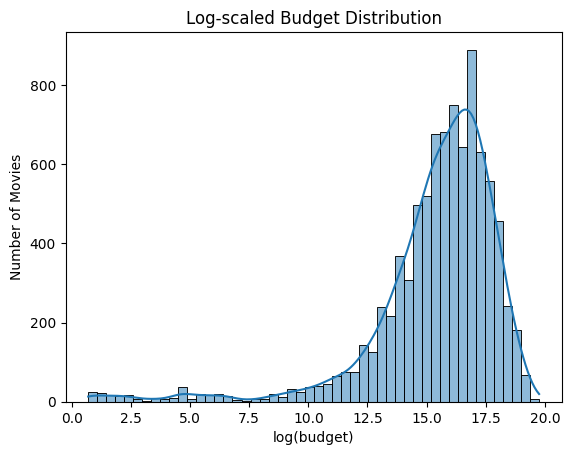

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
df["budget_log"]  = np.log1p(df["budget"])


sns.histplot(df["budget_log"], bins=50, kde=True)
plt.title("Log-scaled Budget Distribution")
plt.xlabel("log(budget)")
plt.ylabel("Number of Movies")
plt.show()

# Aplicam transformarea logaritmica pentru coloana 'budget'
# Aceasta transformare reduce influenta valorilor extreme (outlieri)
# si face distributia mai echilibrata (mai apropiata de o distributie normala)
# Este utila pentru analize statistice si algoritmi de invatare automata





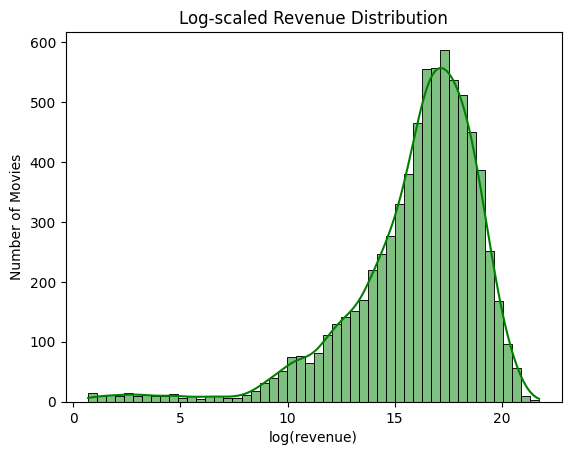

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Log-transform pentru revenue
df["revenue_log"] = np.log1p(df["revenue"])

# Histograma pentru revenue log
sns.histplot(df["revenue_log"], bins=50, kde=True, color="green")
plt.title("Log-scaled Revenue Distribution")
plt.xlabel("log(revenue)")
plt.ylabel("Number of Movies")
plt.show()

# Aplicam transformarea logaritmica si pentru 'revenue'
# Din nou, scopul este sa reducem asimetria si efectul valorilor extreme
# pentru ca veniturile filmelor variaza puternic (de la zero pana la miliarde)



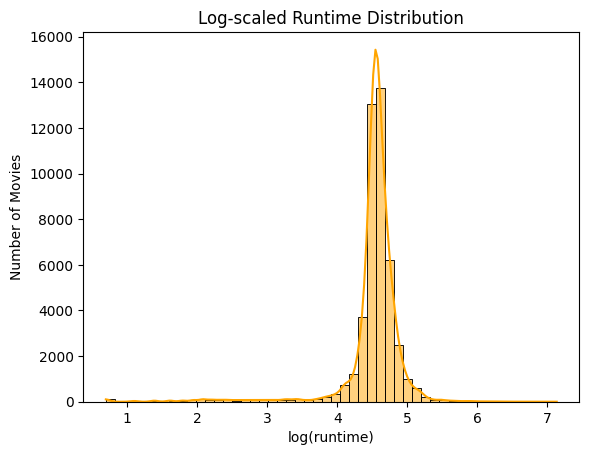

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Aplicam transformarea logaritmica pe runtime
df["runtime_log"] = np.log1p(df["runtime"])

# Vizualizam distributia dupa transformare
sns.histplot(df["runtime_log"], bins=50, kde=True, color="orange")
plt.title("Log-scaled Runtime Distribution")
plt.xlabel("log(runtime)")
plt.ylabel("Number of Movies")
plt.show()


# Aplicam transformarea logaritmica pe coloana 'runtime'
# Aceasta metoda reduce efectul valorilor extreme si face distributia mai echilibrata


In [19]:
df.to_excel("cleaned_movies_metadata.xlsx", index=False)

In [20]:
print("GATA! Notebook rulat cu succes. Datele au fost preprocesate si salvate in 'cleaned_movies_metadata.xlsx'. Treci acum la fisierul 2_Clustering.ipynb")

GATA! Notebook rulat cu succes. Datele au fost preprocesate si salvate in 'cleaned_movies_metadata.xlsx'. Treci acum la fisierul 2_Clustering.ipynb
